# EasyVVUQ - Basic Concepts

This tutorial shows a simple EasyVVUQ workflow in action. The example used here is a simulation of a vertical deflection of a tube. Description of it can be found [here](https://openturns.github.io/openturns/latest/usecases/use_case_deflection_tube.html). This model was chosen since it is intuitively easy to understand even without any background in the relative field. It is also easy to interpret the results. We will use EasyVVUQ to determine the influence each of the input parameters has on the vertical deflection at point ```a```.

The usage of the application is:

```beam <input_file>```

It outputs a single file called output.json, which will look like ```{'g1': x, 'g2': y, 'g3': y}``` where ```g1``` is the vertical displacement at point ```a``` and ```g2```, ```g3``` are displaced angles of the tube at the left and right ends respectively.

The beam.template is a template input file, in JSON format

```{"outfile": "$outfile", "F": $F, "L": $L, "a": $a, "D": $D, "d": $d, "E": $E}```

The values for each key are tags (signified by the $ delimiter) which will be substituted by EasyVVUQ with values to sample the parameter space. In the following tutorial, the template will be used to generate files called input.json that will be the input to each run of ```beam```.

So, for example:

In [ ]:
!echo "{\"outfile\": \"output.json\", \"F\": 1.0, \"L\": 1.5, \"a\": 1.0, \"D\": 0.8, \"d\": 0.1, \"E\": 200000}" > input.json

In [ ]:
!./beam input.json

In [ ]:
!cat output.json

In this tutorial we will see how to use EasyVVUQ to do variance based sensitivity analysis using stochastic collocation. It is one of several methods that EasyVVUQ supports for this purpose (others being Monte Carlo and Polynomial Chaos Expansion methods). While stochastic collocation supports more complicated scenarios we only explore the basic functionality.

# Campaign

In [1]:
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt

In [2]:
params = {
    "F": {"type": "float", "default": 1.0}, 
    "L": {"type": "float", "default": 1.5}, 
    "a": {"type": "float", "min": 0.7, "max": 1.2, "default": 1.0}, 
    "D": {"type": "float", "min": 0.75, "max": 0.85, "default": 0.8},
    "d": {"type": "float", "min": 0.09, "max": 0.11, "default": 0.1},
    "E": {"type": "float", "default": 200000},
    "outfile": {"type": "string", "default": "output.json"}
}

In [3]:
encoder = uq.encoders.GenericEncoder(template_fname='beam.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.JSONDecoder(target_filename='output.json', output_columns=['g1'])

In [4]:
campaign = uq.Campaign(name='beam', params=params, encoder=encoder, decoder=decoder)

In [5]:
vary = {
    "F": cp.Normal(1, 0.1),
    "L": cp.Normal(1.5, 0.01),
    "a": cp.Uniform(0.7, 1.2),
    "D": cp.Triangle(0.75, 0.8, 0.85),
#    "d": cp.Triangle(0.09, 0.1, 0.11),
#    "E": cp.Normal(200000, 2000)
}

In [6]:
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=3))

Received integer polynomial order, assuming isotropic grid


In [7]:
execution = campaign.sample_and_apply(action=uq.actions.ExecuteLocalV2("beam input.json"), batch_size=8)

In [8]:
execution.start();

The execution will take a while since we need to generate several thousand samples. We asked it to evaluate 8 samples in parallel. You can track progress by using the ```progress``` method. You can also check progress automatically and resume execution after it is done if you want to run this inside a script rather than interactively.

In [21]:
execution.progress()

{'ready': 0, 'active': 0, 'finished': 4096, 'failed': 0}

In [22]:
results = campaign.analyse(qoi_cols=['g1'])

Loading samples...
done
Computing Sobol indices...
done.


(0.0, 100.0, 0.0, 100.0)

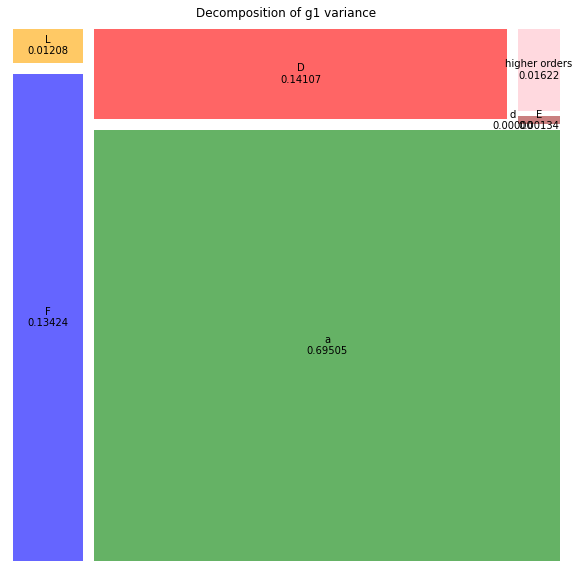

In [23]:
results.plot_sobols_treemap('g1', figsize=(10, 10))
plt.axis('off');

Alternatively you can get the Sobol index values using the method calls below.

In [ ]:
results.sobols_first()

Alternatively you can try using Stochastic Collocation or Monte Carlo method for variance based sensitivity analysis. The procedure is exactly the same. For details please see the respective tutorial notebooks. EasyVVUQ also provides Markov-Chain Monte Carlo methods.